# Capstone Project : In-depth Analysis (Machine Learning)

> This section serves a tool to demonstrate utilizing supervised learning techniques to build  predictive models.


## Table of Contents
1. [Introduction](#intro)<br>
2. [Pre Processing Data](#pre) <br>
    2.1 [Access Collinearity](#ac)<br>
    2.2 [Standardising and Normalising](#sn)<br>
    2.3 [Rescalling](#ra)<br>
3. [Random Forest](#df)<br>
    3.1 [Random Hyperparameter Grid](#rhg)<br>
    3.2 [Grid Search with Cross Validation](#gscv)<br>
    3.3 [Features Importance](#fi)<br>
4. [Neural Network](#nn)<br>
    4.1 [Three Layer Neural Network](#nn2)<br>
    4.2 [Four Layer Neural Network with L1 Regularization and More Epochs](#nn3)<br>
    4.3 [Four Layer Neural Network with SGD Optimizer](#nn4)<br>
5. [Conclusion & Recommandation](#cr)<br>

## 1. Introduction and Prodiction 
<a id="intro"> </a>
In this section, we will apply machine learning techniques to 

In [335]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time

from statsmodels.tsa.seasonal import seasonal_decompose



import pydot as pyd
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pyd

from tensorflow import keras
from keras import models, layers, optimizers, regularizers

In [120]:
# load the data
listings_model = pd.read_csv('listings_clean_model.csv')

## 2. Pre-Processing Data
<a id="pre"> </a>

In [121]:
# transform categorical data into dummy
transformed_listings = pd.get_dummies(listings_model)

### 2.1 Assessed for multi-collinearity.

In [122]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """    
    # Set the style of the visualization
    sns.set(style="white")
    # Create a covariance matrix
    corr = df.corr()
    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, 
                linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max()
               );

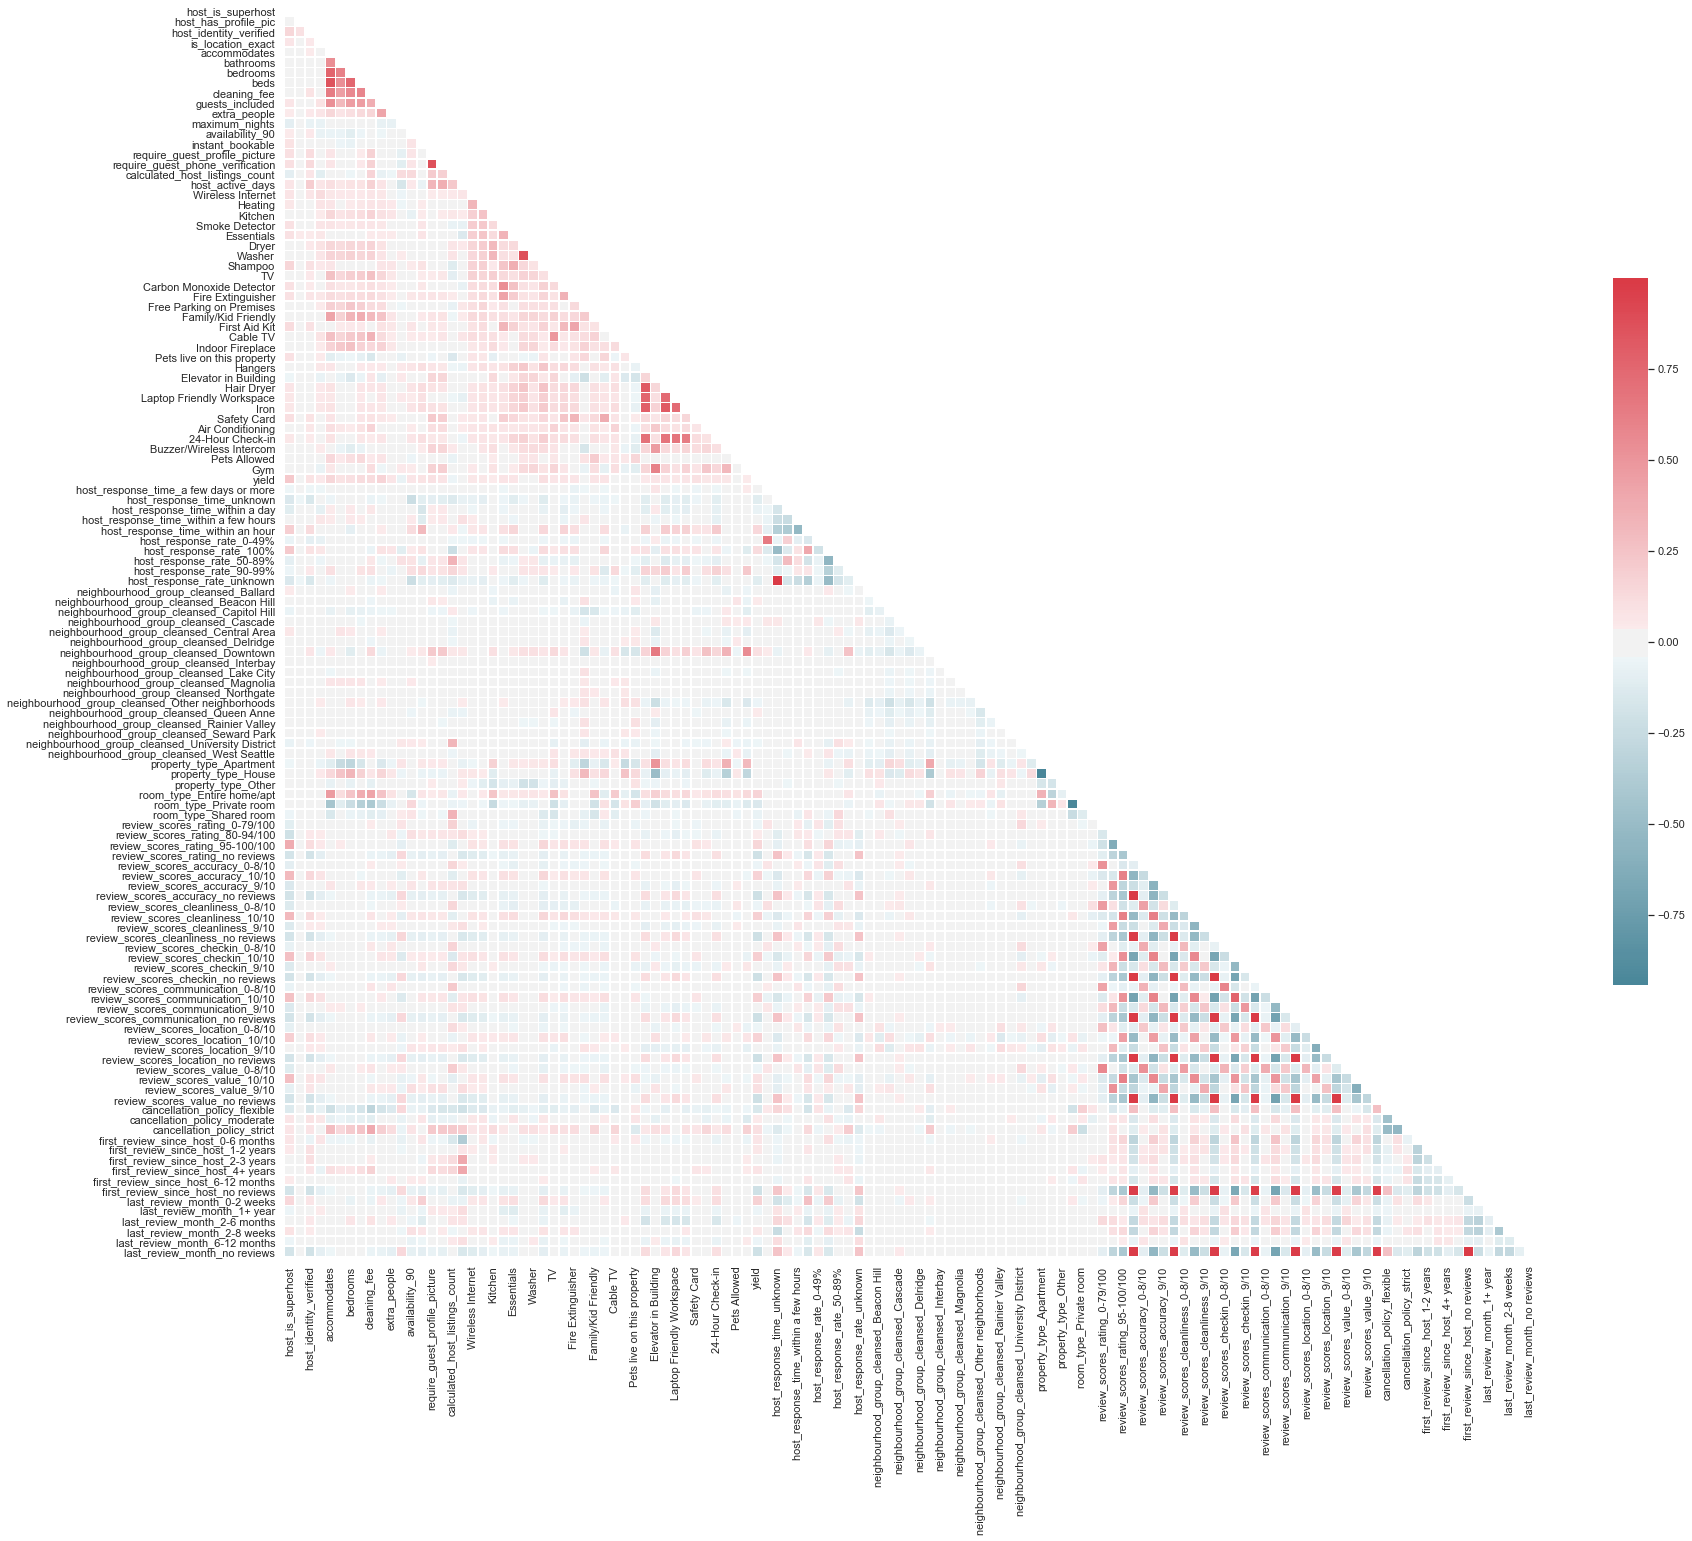

In [123]:
multi_collinearity_heatmap(transformed_listings, figsize=(28,26))

> we have spot some highly correalted region above, then we will zoom in the area that make up with highly correlated features.

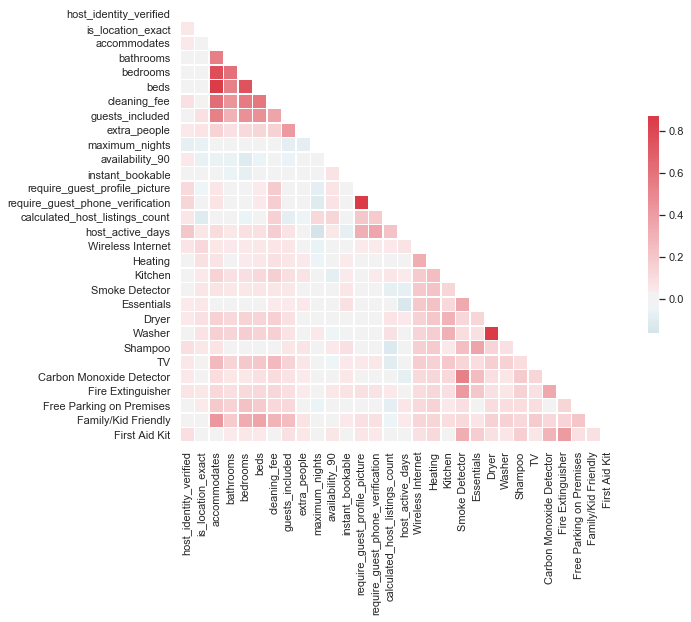

In [124]:
multi_collinearity_heatmap(transformed_listings.iloc[:,2:32], figsize=(12,8))

>> __Zone 1 zoom-in__:
- The first area we should focus on features `accommodates`, `bathroom`, `beds`, `cleaning_fee` and `guests_included`.
- When we use the Airbnb App, the very important feature is how many guests the listing can accommodate, so we will keep `accommodates` and  `cleaning fee`.
- Also, we will only keep one of `require_guest_phone_verification` and `require_guest_profile_picture`.

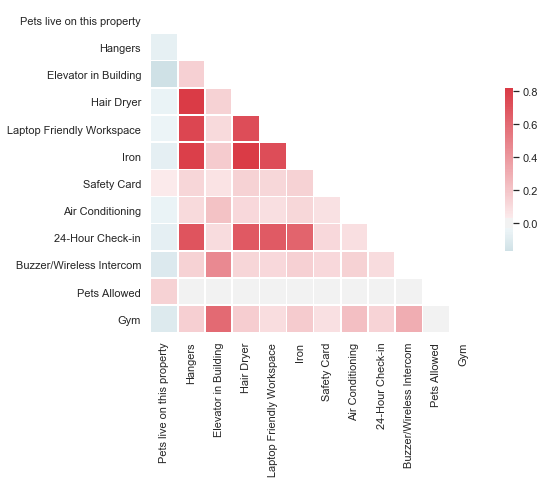

In [125]:
multi_collinearity_heatmap(transformed_listings.iloc[:,34:46], figsize=(10,6))

>> __Zone 2 zoom-in__: 
<br>Some amenities are highly correlated, such as `Hair Dryer`, `Hangers`, `Laptop Friendly workspace`, `Iron` and `24-Hour Chech-In`, we will drop the `Hangers` and `Iron`.

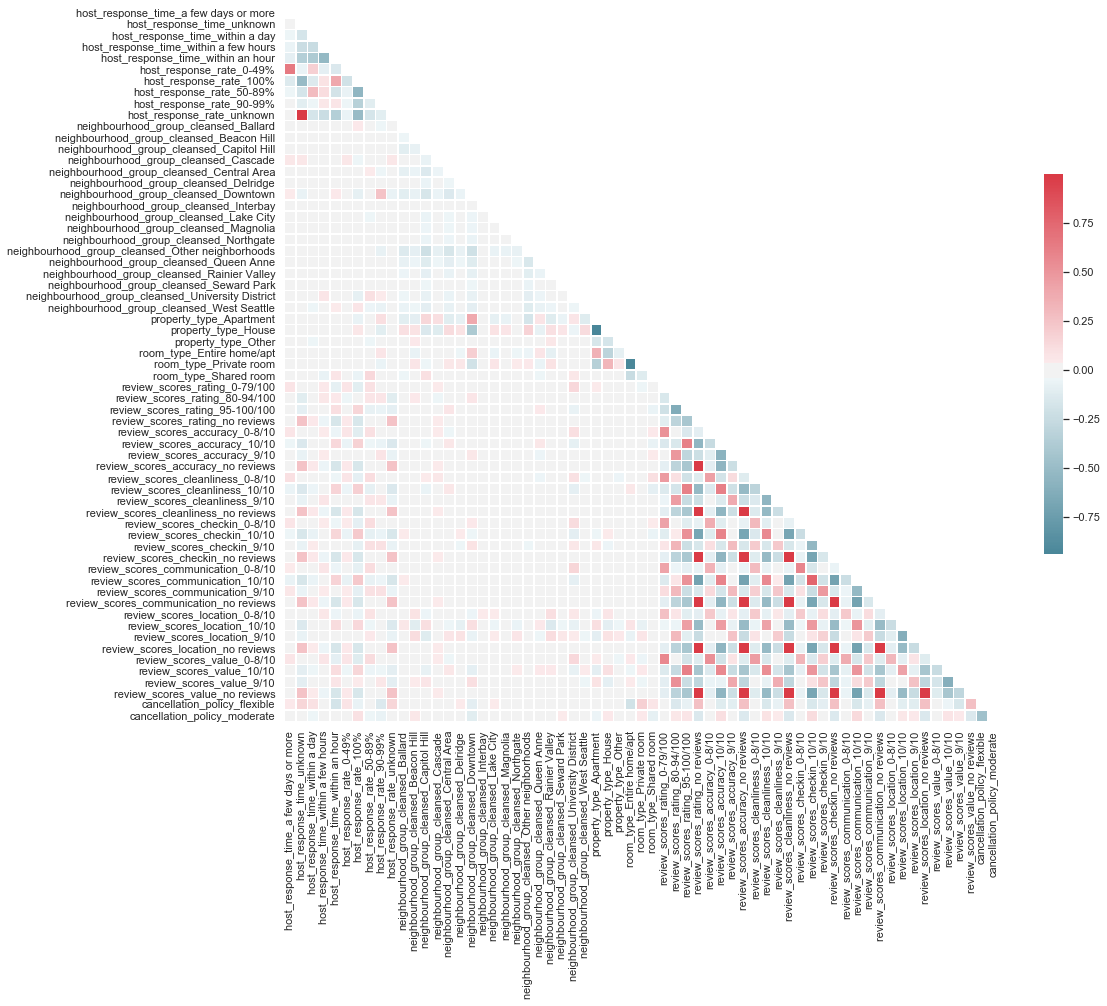

In [126]:
multi_collinearity_heatmap(transformed_listings.iloc[:,47:110], figsize=(16,14))

>> __Zone 3 zoom-in__:
<br> - Unsuerpisingly, all the `no_review` groups are highly correlated, and we will drop all of them.
<br> - The same `no_review` high correlation for host response rate and time, so one of them will be dropped.
<br> - `property_type_house` and `proterty_type_apartment` have high negative correlation, so are `room_type_private room` and `room_type_Entire_home/apartment`, each one of them will be dropped.

In [127]:
# Drop features
drop_list = ['bathrooms', 'beds', 'guests_included', 'Dryer', 'bedrooms',
             'require_guest_profile_picture', 'Hangers', 
             'Iron', 'host_response_rate_unknown',
             'property_type_Apartment', 'room_type_Private room']
drop_list.extend(list(transformed_listings.columns[transformed_listings.columns.str.endswith('no reviews')]))

transformed_listings.drop(drop_list, axis=1, inplace=True)

Let's check the results - the correaltion plot looks better. 

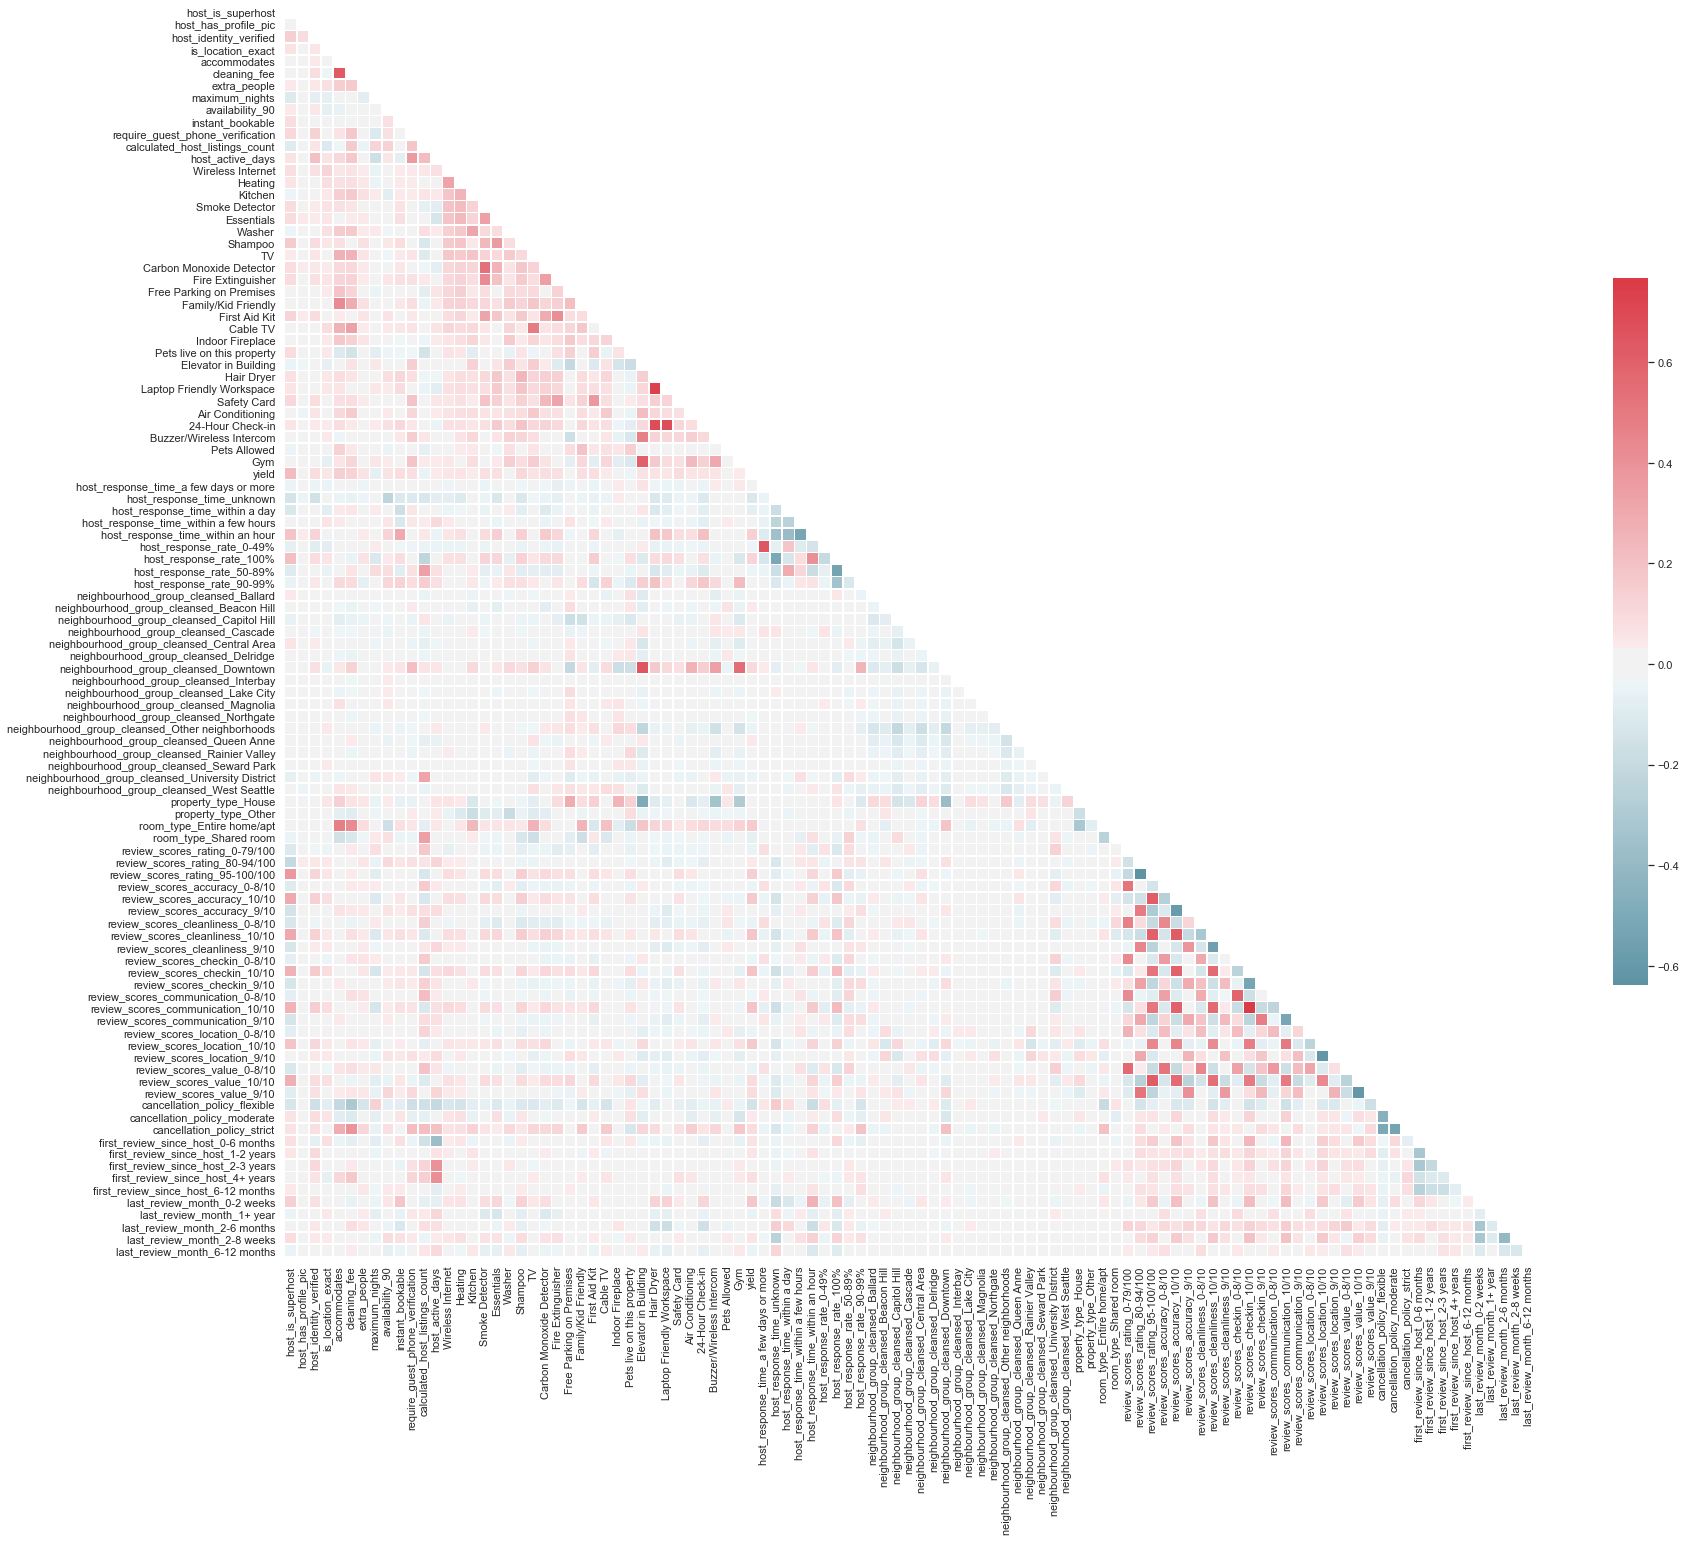

In [128]:
multi_collinearity_heatmap(transformed_listings, figsize=(28,26))

### 2.2 Standardising and Normalising
<a id="sn"> </a>
we will apply log transformation for numerical features that are postively skewed.

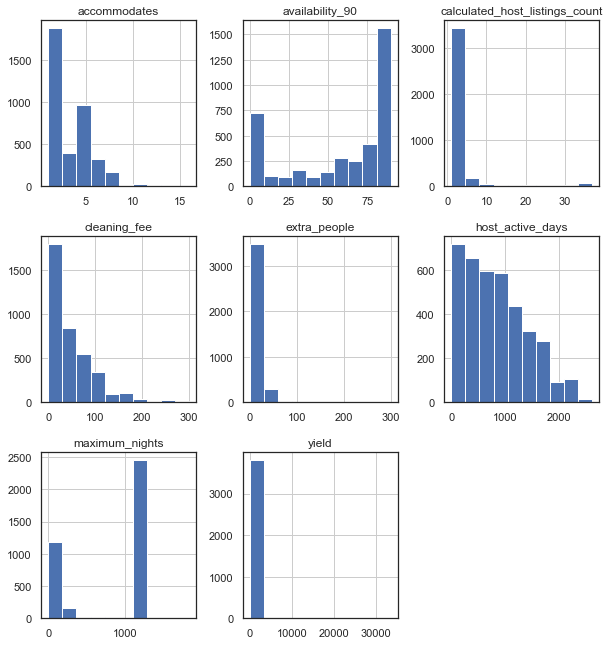

In [131]:
numerical_columns = ['accommodates', 'cleaning_fee', 'extra_people', 'maximum_nights', 
                     'availability_90', 'calculated_host_listings_count', 'host_active_days',
                     'yield']

transformed_listings[numerical_columns].hist(figsize=(10,11));

In [132]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_listings[col] = transformed_listings[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_listings[col] = np.log(transformed_listings[col])

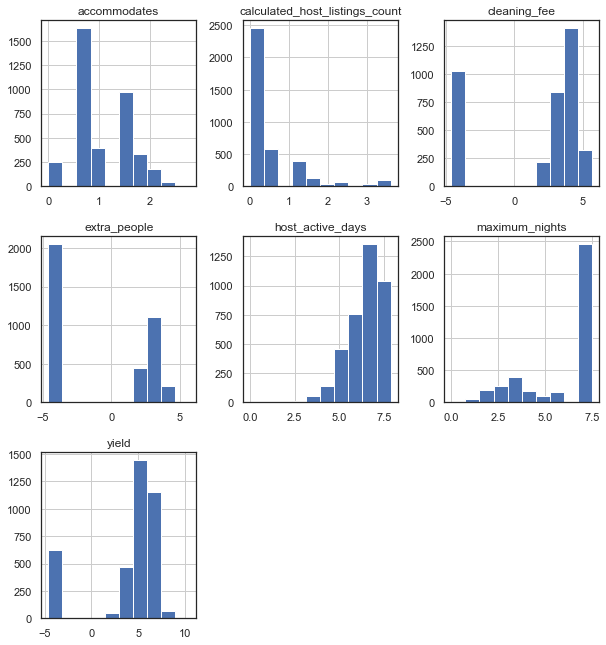

In [134]:

transformed_listings[numerical_columns].hist(figsize=(10,11));

### 2.3 Rescalling
<a id="ra"> </a>

In [259]:
# Separating X and y
X = transformed_listings.drop('yield', axis=1)
y = transformed_listings['yield']

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

## 3. Random Forest
<a id="rf"> </a>

### 3.1 Random Hyperparameter Grid
<a id="rhg"> </a>

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

In [141]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 47.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [144]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(rf_random.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
25,6.062035,0.489918,0.255104,0.030464,400,2,1,sqrt,None,False,"{'n_estimators': 400, 'min_samples_split': 2, ...",0.959164,0.963290,0.961578,0.961344,0.001693,1
7,6.561740,0.022587,0.312168,0.008802,600,5,1,sqrt,60,False,"{'n_estimators': 600, 'min_samples_split': 5, ...",0.958827,0.963291,0.961913,0.961344,0.001867,2
32,9.914103,0.051570,0.417817,0.017682,800,5,1,sqrt,100,False,"{'n_estimators': 800, 'min_samples_split': 5, ...",0.958552,0.963149,0.961946,0.961216,0.001947,3
21,19.324049,0.405435,0.891648,0.050412,1600,5,1,sqrt,70,False,"{'n_estimators': 1600, 'min_samples_split': 5,...",0.958535,0.963147,0.961566,0.961083,0.001914,4
24,16.134009,0.420534,0.678972,0.017602,1400,5,1,sqrt,80,False,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.958302,0.963016,0.961702,0.961007,0.001986,5


In [156]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [162]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

print("Bese Model")
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print()
print("Best Random Search Model")
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Bese Model
Model Performance
Average Error: 0.5549 degrees.
Accuracy = 88.94%.

Best Random Search Model
Model Performance
Average Error: 0.5380 degrees.
Accuracy = 89.44%.
Improvement of 0.56%.


### 3.2 Grid Search with Cross Validation
<a id="gscv"> </a>

In [172]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [173]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 15.4min finished


{'bootstrap': False,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [174]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.6595 degrees.
Accuracy = 90.06%.
Improvement of 1.26%.


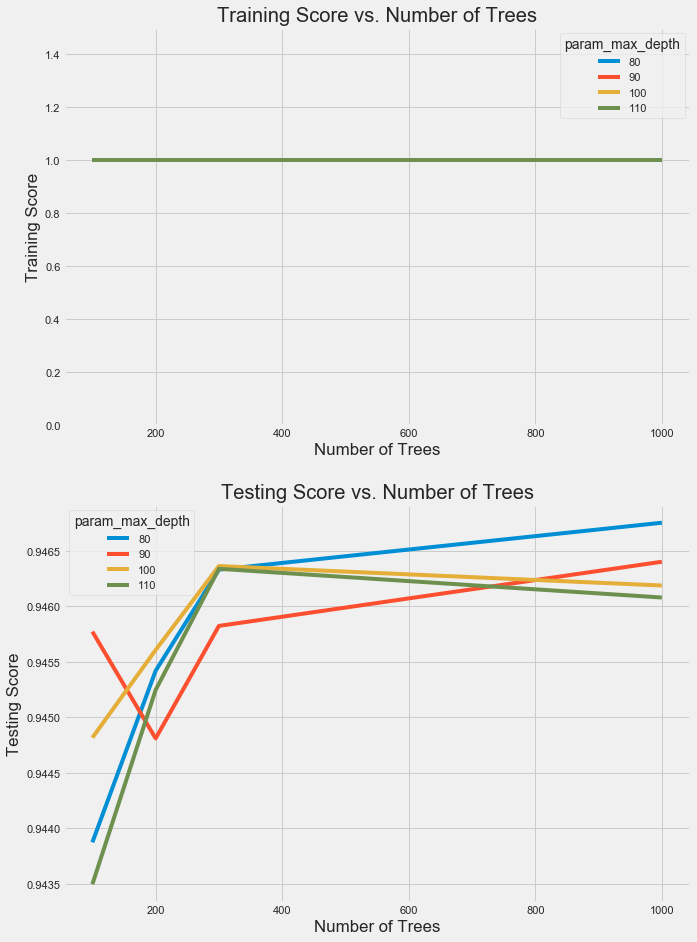

In [221]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

results_sub = results[(results.param_max_features== 3)&(results.param_min_samples_leaf ==1)&(results.param_min_samples_split==2)]

df_train = results_sub.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
df_test = results_sub.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

#plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,15))
df_train.plot(ax =ax1)
ax1.set_ylabel('Training Score')
ax1.set_xlabel('Number of Trees')
ax1.set_ylim(0, 1.5)
ax1.set_title("Training Score vs. Number of Trees")

df_test.plot(ax =ax2)
ax2.set_ylabel('Testing Score')
ax2.set_xlabel('Number of Trees')
ax2.set_title("Testing Score vs. Number of Trees")

plt.show()

>> We then visualized the cross-validation process, with other parameters fixed as what they are in the best grid search model,
n_estimators = number of trees in the forest
- max_features = max number of features considered for splitting a node, as 3
- min_samples_split = min number of data points placed in a node before the node is split, as 1,
- min_samples_leaf = min number of data points allowed in a leaf node, as 2, 
- bootstrap = method for sampling data points (with or without replacement), as False,
<br/><br/>
__We visualize both the training and testing score against the number of trees `n_estimators `, grouped by different `max_depth`__
- n_estimators = number of trees in the forest, as from 100 to 1000,
- max_depth = max number of levels in each decision tree, as (80, 90, 100, 110),
<br>
we can see when we reach the best performance - with 1000 number of trees in the forest and 80 as the max number of levels in each decision tree.

In [181]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
39,10.013988,0.054658,0.854618,0.109623,False,80,3,1,2,1000,...,0.949145,0.948770,0.946754,0.003120,1,1.0,1.0,1.0,1.0,9.508412e-08
111,11.717976,0.073876,0.970306,0.052861,False,90,3,1,2,1000,...,0.949185,0.948055,0.946403,0.003169,2,1.0,1.0,1.0,1.0,9.508412e-08
182,4.000513,0.207746,0.228181,0.010330,False,100,3,1,2,300,...,0.947898,0.949121,0.946364,0.003075,3,1.0,1.0,1.0,1.0,9.508413e-08
254,3.735915,0.202461,0.429103,0.087436,False,110,3,1,2,300,...,0.948399,0.947557,0.946339,0.002343,4,1.0,1.0,1.0,1.0,9.508412e-08
38,3.036197,0.014710,0.203571,0.010221,False,80,3,1,2,300,...,0.950260,0.948030,0.946332,0.004082,5,1.0,1.0,1.0,1.0,9.508412e-08


In [236]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(X_train.columns), 
                                'importance': best_grid.feature_importances_})

# Show the top 50 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(50)

,feature,importance
0,review_scores_checkin_10/10,0.098477
1,review_scores_communication_10/10,0.095529
2,review_scores_accuracy_10/10,0.068878
3,review_scores_cleanliness_10/10,0.060344
4,review_scores_location_10/10,0.056486
5,review_scores_rating_80-94/100,0.039072
6,review_scores_value_9/10,0.036904
7,review_scores_rating_95-100/100,0.036671
8,review_scores_value_10/10,0.036363
9,first_review_since_host_0-6 months,0.029132


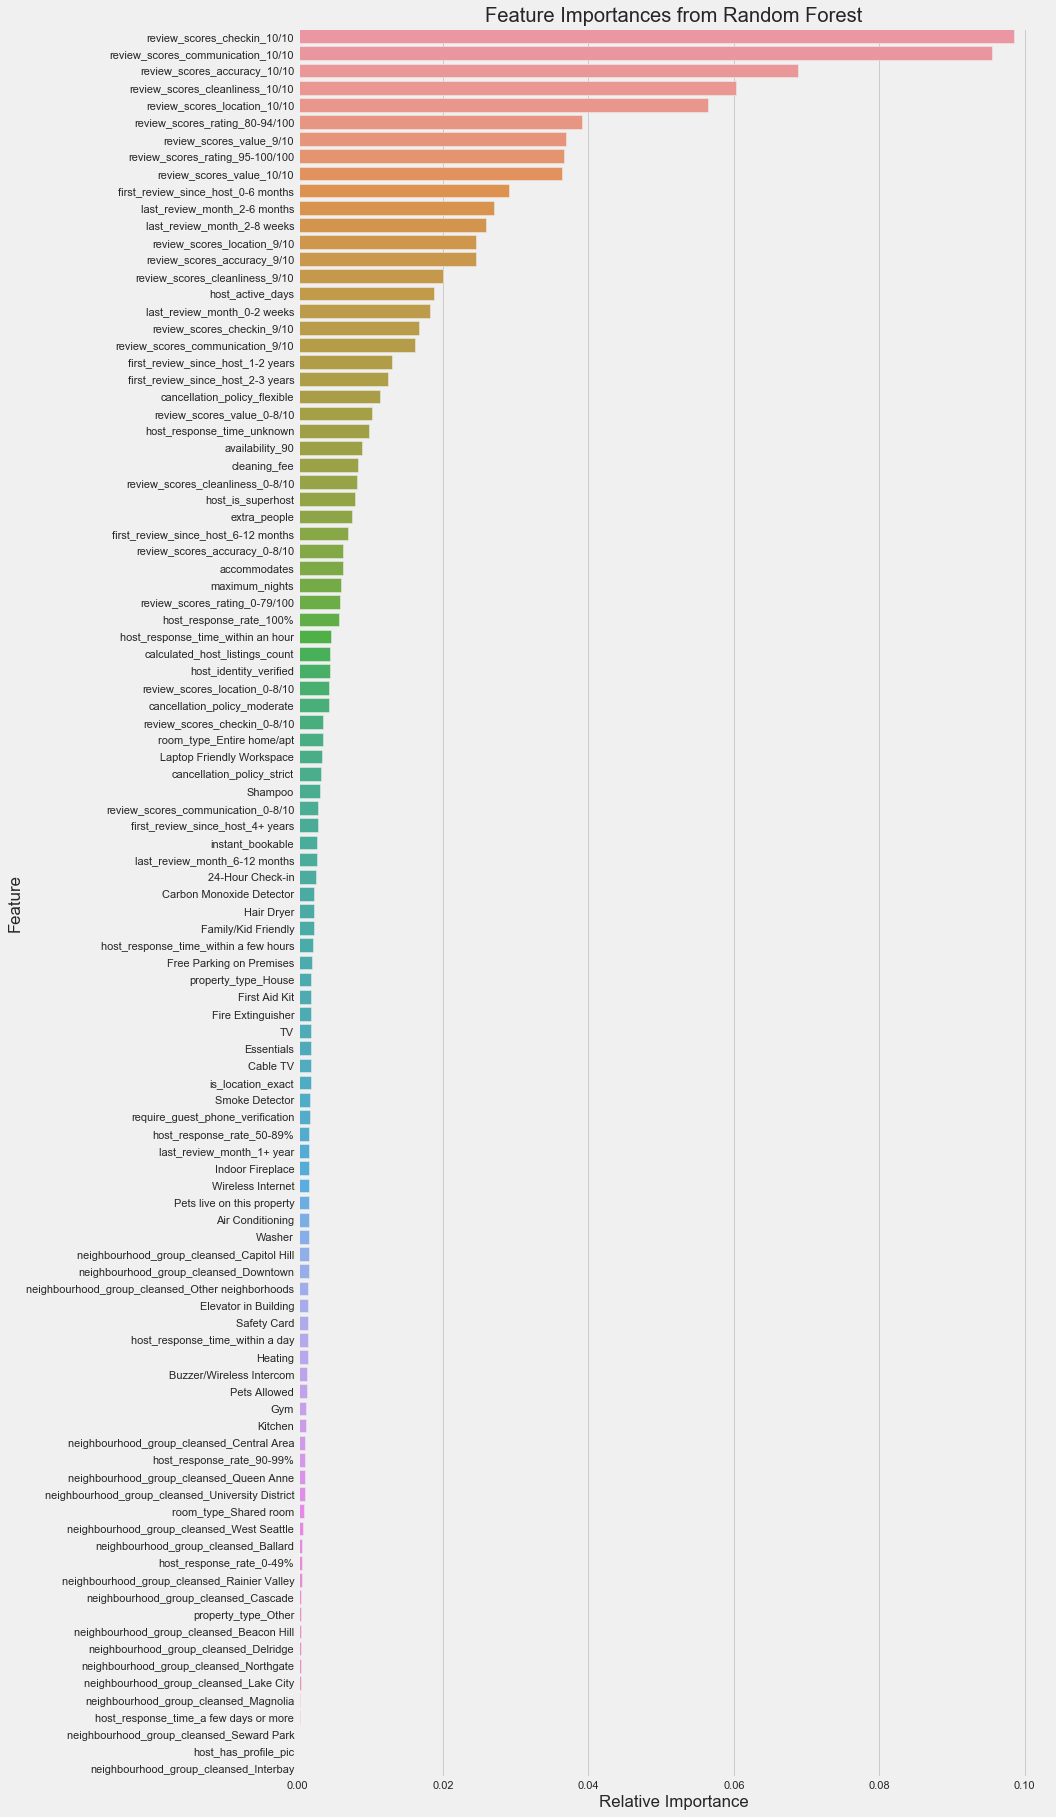

In [243]:
#group by host listing count
plt.figure(figsize=(12, 30))
sns.barplot(x='importance', y='feature', 
            data=feature_results)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.show() 

>> The top 9 important features are review socre, then it gets to the features `first_review_since_host_0-6 months`,
1.  review_scores_communication_10/10
2.	review_scores_checkin_10/10	
3.	review_scores_accuracy_10/10	
4.	review_scores_location_10/10	
5.	review_scores_cleanliness_10/10	
6.	review_scores_rating_80-94/100	
7.	review_scores_value_10/10	
8.	review_scores_rating_95-100/100	
9.	review_scores_value_9/10
10. first_review_since_host_0-6 months
<br/><br/>

Look through the top 50 important features, 
- The review score and host activeness are on the very top and medium part and they take up a big proportion of the list,
- In the medium of the list,  `cleaning_fee`, `avaliability_90` and some amenities are also important for prediction,
- And most of the amenities and grouped neighborhoods show up in the medium and bottom of the list.



### Summary

We can see that the random grid search returns the best parameter, with refit using that best parameter returns better model than the default mode, and beyond that, we use grid search with cross-validation with a smaller parameter range and returns the best model above all.


   Model                                           |   Accuracy   |   Improvement(to base model)
-------------------------------------------------- | -------------| -----------------------------
Base Model                                         | 88.94%       |  - 
Best Model with Random Grid Search                 | 89.44%       |  0.56%
Best Model with Grid Search & Cross Validation     | 90.06%       |  1.26%

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 128)               13184     
_________________________________________________________________
dense_71 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_72 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 257       
Total params: 112,257
Trainable params: 112,257
Non-trainable params: 0
_________________________________________________________________
None


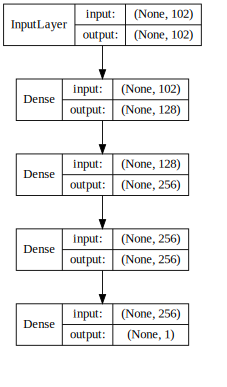

In [323]:


# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())


# Visualising the neural network
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names,dpi=65).create(prog='dot',format='svg'))
plot_keras_model(nn2, show_shapes=True, show_layer_names=False)


In [326]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Train on 2748 samples, validate on 306 samples
Epoch 1/100
2748/2748 [==============================] - 2s 581us/step - loss: 18.3551 - mean_squared_error: 18.3551 - val_loss: 12.1157 - val_mean_squared_error: 12.1157
Epoch 2/100
2748/2748 [==============================] - 0s 93us/step - loss: 7.5386 - mean_squared_error: 7.5386 - val_loss: 5.1094 - val_mean_squared_error: 5.1094
Epoch 3/100
2748/2748 [==============================] - 0s 95us/step - loss: 3.5272 - mean_squared_error: 3.5272 - val_loss: 2.2921 - val_mean_squared_error: 2.2921
Epoch 4/100
2748/2748 [==============================] - 0s 99us/step - loss: 1.5902 - mean_squared_error: 1.5902 - val_loss: 1.5534 - val_mean_squared_error: 1.5534
Epoch 5/100
2748/2748 [==============================] - 0s 98us/step - loss: 1.0882 - mean_squared_error: 1.0882 - val_loss: 1.1999 - val_mean_squared_error: 1.1999
Epoch 6/100
2748/2748 [==============================] - 0s 96us/step - loss: 0.9238 - mean_squared_error: 0.9238 - va

2748/2748 [==============================] - 0s 99us/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.8180 - val_mean_squared_error: 0.8180
Epoch 50/100
2748/2748 [==============================] - 0s 78us/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.8279 - val_mean_squared_error: 0.8279
Epoch 51/100
2748/2748 [==============================] - 0s 78us/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.8247 - val_mean_squared_error: 0.8247
Epoch 52/100
2748/2748 [==============================] - 0s 79us/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.8308 - val_mean_squared_error: 0.8308
Epoch 53/100
2748/2748 [==============================] - 0s 77us/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.8346 - val_mean_squared_error: 0.8346
Epoch 54/100
2748/2748 [==============================] - 0s 79us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.8362 - val_mean_squared_error: 0.8362
Epoch 55/10

2748/2748 [==============================] - 0s 82us/step - loss: 8.4625e-04 - mean_squared_error: 8.4625e-04 - val_loss: 0.8597 - val_mean_squared_error: 0.8597
Epoch 98/100
2748/2748 [==============================] - 0s 79us/step - loss: 6.8020e-04 - mean_squared_error: 6.8020e-04 - val_loss: 0.8639 - val_mean_squared_error: 0.8639
Epoch 99/100
2748/2748 [==============================] - 0s 76us/step - loss: 5.6212e-04 - mean_squared_error: 5.6212e-04 - val_loss: 0.8605 - val_mean_squared_error: 0.8605
Epoch 100/100
2748/2748 [==============================] - 0s 78us/step - loss: 4.5588e-04 - mean_squared_error: 4.5588e-04 - val_loss: 0.8662 - val_mean_squared_error: 0.8662
Time taken to run: 0.5 minutes


In [327]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.0872
Validation MSE: 0.9482

Training r2: 0.9942
Validation r2: 0.9363


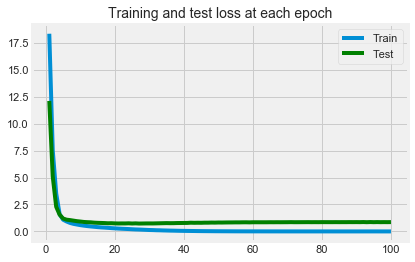

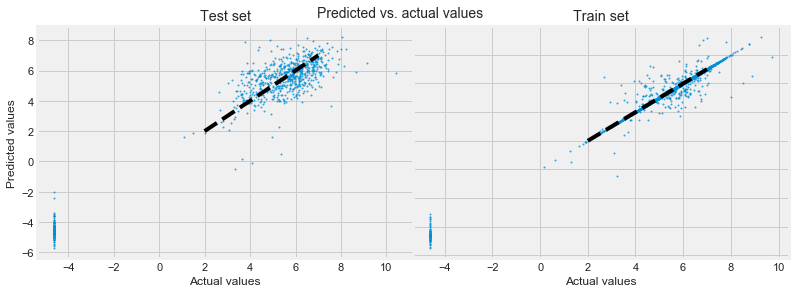

In [328]:
nn_model_evaluation(nn2)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 128)               13184     
_________________________________________________________________
dense_66 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_67 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_68 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 513       
Total params: 244,097
Trainable params: 244,097
Non-trainable params: 0
_________________________________________________________________
None


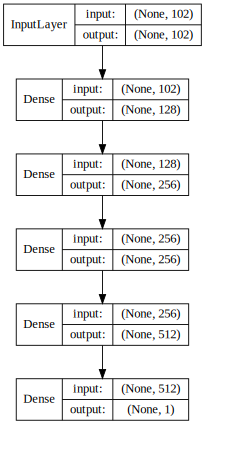

In [312]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
plot_keras_model(nn3, show_shapes=True, show_layer_names=False)

In [313]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Train on 2748 samples, validate on 306 samples
Epoch 1/150
2748/2748 [==============================] - 3s 973us/step - loss: 76.4354 - mean_squared_error: 16.4729 - val_loss: 67.9086 - val_mean_squared_error: 10.8535
Epoch 2/150
2748/2748 [==============================] - 0s 170us/step - loss: 61.9733 - mean_squared_error: 7.3845 - val_loss: 57.0795 - val_mean_squared_error: 5.5806
Epoch 3/150
2748/2748 [==============================] - 0s 180us/step - loss: 52.9883 - mean_squared_error: 3.8924 - val_loss: 48.5088 - val_mean_squared_error: 2.3669
Epoch 4/150
2748/2748 [==============================] - 1s 199us/step - loss: 45.3966 - mean_squared_error: 1.5065 - val_loss: 42.4685 - val_mean_squared_error: 1.3859
Epoch 5/150
2748/2748 [==============================] - 1s 292us/step - loss: 39.9831 - mean_squared_error: 1.0764 - val_loss: 37.4398 - val_mean_squared_error: 1.1823
Epoch 6/150
2748/2748 [==============================] - 1s 186us/step - loss: 35.2220 - mean_squared_erro

2748/2748 [==============================] - 0s 130us/step - loss: 2.1541 - mean_squared_error: 0.2990 - val_loss: 2.3483 - val_mean_squared_error: 0.5289
Epoch 50/150
2748/2748 [==============================] - 0s 140us/step - loss: 2.0879 - mean_squared_error: 0.2971 - val_loss: 2.2673 - val_mean_squared_error: 0.5101
Epoch 51/150
2748/2748 [==============================] - 1s 204us/step - loss: 2.0250 - mean_squared_error: 0.2928 - val_loss: 2.2287 - val_mean_squared_error: 0.5303
Epoch 52/150
2748/2748 [==============================] - 0s 142us/step - loss: 1.9704 - mean_squared_error: 0.2915 - val_loss: 2.1692 - val_mean_squared_error: 0.5210
Epoch 53/150
2748/2748 [==============================] - 0s 146us/step - loss: 1.9206 - mean_squared_error: 0.2922 - val_loss: 2.1213 - val_mean_squared_error: 0.5151
Epoch 54/150
2748/2748 [==============================] - 0s 135us/step - loss: 1.8767 - mean_squared_error: 0.2953 - val_loss: 2.0511 - val_mean_squared_error: 0.4978
Epoch

Epoch 98/150
2748/2748 [==============================] - 0s 167us/step - loss: 0.9790 - mean_squared_error: 0.2169 - val_loss: 1.2671 - val_mean_squared_error: 0.5089
Epoch 99/150
2748/2748 [==============================] - 0s 161us/step - loss: 0.9804 - mean_squared_error: 0.2247 - val_loss: 1.2252 - val_mean_squared_error: 0.4746
Epoch 100/150
2748/2748 [==============================] - 0s 159us/step - loss: 0.9660 - mean_squared_error: 0.2176 - val_loss: 1.2250 - val_mean_squared_error: 0.4803
Epoch 101/150
2748/2748 [==============================] - 0s 167us/step - loss: 0.9526 - mean_squared_error: 0.2102 - val_loss: 1.2086 - val_mean_squared_error: 0.4708
Epoch 102/150
2748/2748 [==============================] - 0s 173us/step - loss: 0.9420 - mean_squared_error: 0.2064 - val_loss: 1.2156 - val_mean_squared_error: 0.4838
Epoch 103/150
2748/2748 [==============================] - 0s 167us/step - loss: 0.9377 - mean_squared_error: 0.2080 - val_loss: 1.1973 - val_mean_squared_er

2748/2748 [==============================] - 0s 170us/step - loss: 0.7635 - mean_squared_error: 0.1708 - val_loss: 1.0669 - val_mean_squared_error: 0.4763
Epoch 147/150
2748/2748 [==============================] - 0s 157us/step - loss: 0.7575 - mean_squared_error: 0.1668 - val_loss: 1.0695 - val_mean_squared_error: 0.4801
Epoch 148/150
2748/2748 [==============================] - 0s 162us/step - loss: 0.7615 - mean_squared_error: 0.1730 - val_loss: 1.0797 - val_mean_squared_error: 0.4913
Epoch 149/150
2748/2748 [==============================] - 0s 163us/step - loss: 0.7600 - mean_squared_error: 0.1728 - val_loss: 1.0656 - val_mean_squared_error: 0.4788
Epoch 150/150
2748/2748 [==============================] - 0s 172us/step - loss: 0.7573 - mean_squared_error: 0.1711 - val_loss: 1.0738 - val_mean_squared_error: 0.4904
Time taken to run: 1.3 minutes


Training MSE: 0.186
Validation MSE: 0.6843

Training r2: 0.9877
Validation r2: 0.9541


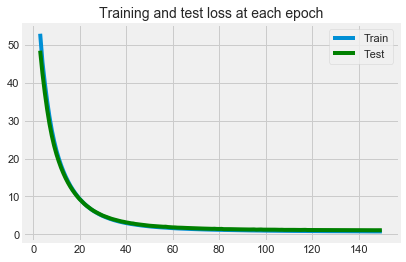

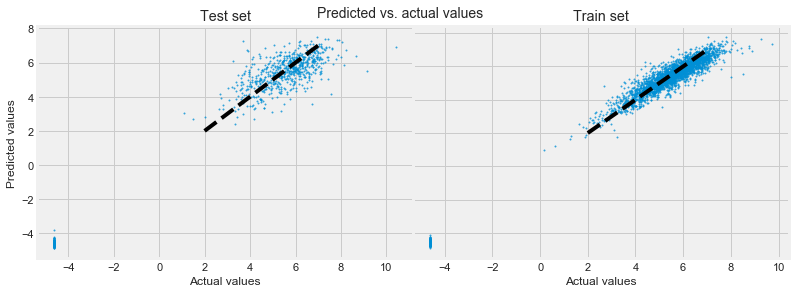

In [314]:
nn_model_evaluation(nn3, skip_epochs=2)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 128)               13184     
_________________________________________________________________
dense_75 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_76 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_77 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 513       
Total params: 244,097
Trainable params: 244,097
Non-trainable params: 0
_________________________________________________________________
None


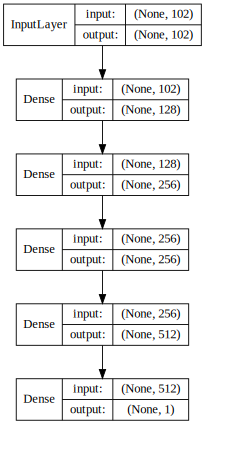

In [330]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())
# Visualising the neural network
plot_keras_model(nn4, show_shapes=True, show_layer_names=False)

In [331]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

Train on 2748 samples, validate on 306 samples
Epoch 1/150
2748/2748 [==============================] - 4s 1ms/step - loss: 75.5014 - mean_squared_error: 13.5646 - val_loss: 72.1382 - val_mean_squared_error: 10.5682
Epoch 2/150
2748/2748 [==============================] - 1s 213us/step - loss: 69.9685 - mean_squared_error: 8.6857 - val_loss: 69.6246 - val_mean_squared_error: 8.6880
Epoch 3/150
2748/2748 [==============================] - 1s 214us/step - loss: 66.3109 - mean_squared_error: 5.6807 - val_loss: 68.7600 - val_mean_squared_error: 8.5100
Epoch 4/150
2748/2748 [==============================] - 0s 181us/step - loss: 63.2304 - mean_squared_error: 3.2442 - val_loss: 61.3732 - val_mean_squared_error: 1.7365
Epoch 5/150
2748/2748 [==============================] - 0s 131us/step - loss: 61.2278 - mean_squared_error: 1.8888 - val_loss: 60.3848 - val_mean_squared_error: 1.4119
Epoch 6/150
2748/2748 [==============================] - 0s 177us/step - loss: 59.7788 - mean_squared_error:

2748/2748 [==============================] - 0s 133us/step - loss: 34.8651 - mean_squared_error: 0.3872 - val_loss: 34.8961 - val_mean_squared_error: 0.6870
Epoch 50/150
2748/2748 [==============================] - 0s 116us/step - loss: 34.3933 - mean_squared_error: 0.3951 - val_loss: 34.4065 - val_mean_squared_error: 0.6743
Epoch 51/150
2748/2748 [==============================] - 0s 151us/step - loss: 33.9250 - mean_squared_error: 0.4033 - val_loss: 33.9335 - val_mean_squared_error: 0.6735
Epoch 52/150
2748/2748 [==============================] - 0s 156us/step - loss: 33.4329 - mean_squared_error: 0.3855 - val_loss: 33.4556 - val_mean_squared_error: 0.6691
Epoch 53/150
2748/2748 [==============================] - 0s 124us/step - loss: 32.9560 - mean_squared_error: 0.3784 - val_loss: 32.9962 - val_mean_squared_error: 0.6786
Epoch 54/150
2748/2748 [==============================] - 0s 132us/step - loss: 32.4919 - mean_squared_error: 0.3800 - val_loss: 32.6126 - val_mean_squared_error: 

2748/2748 [==============================] - 0s 130us/step - loss: 15.9451 - mean_squared_error: 0.3194 - val_loss: 16.0529 - val_mean_squared_error: 0.5958
Epoch 98/150
2748/2748 [==============================] - 0s 123us/step - loss: 15.6328 - mean_squared_error: 0.3094 - val_loss: 15.7549 - val_mean_squared_error: 0.5996
Epoch 99/150
2748/2748 [==============================] - 0s 125us/step - loss: 15.3418 - mean_squared_error: 0.3151 - val_loss: 15.4530 - val_mean_squared_error: 0.5896
Epoch 100/150
2748/2748 [==============================] - 0s 145us/step - loss: 15.0516 - mean_squared_error: 0.3182 - val_loss: 15.1662 - val_mean_squared_error: 0.5908
Epoch 101/150
2748/2748 [==============================] - 0s 136us/step - loss: 14.7572 - mean_squared_error: 0.3136 - val_loss: 14.8853 - val_mean_squared_error: 0.6040
Epoch 102/150
2748/2748 [==============================] - 0s 122us/step - loss: 14.4623 - mean_squared_error: 0.3059 - val_loss: 14.6000 - val_mean_squared_erro

2748/2748 [==============================] - 0s 126us/step - loss: 5.5947 - mean_squared_error: 0.3071 - val_loss: 5.7851 - val_mean_squared_error: 0.5581
Epoch 146/150
2748/2748 [==============================] - 0s 131us/step - loss: 5.4972 - mean_squared_error: 0.3345 - val_loss: 5.7398 - val_mean_squared_error: 0.6564
Epoch 147/150
2748/2748 [==============================] - 0s 129us/step - loss: 5.3696 - mean_squared_error: 0.3346 - val_loss: 5.4795 - val_mean_squared_error: 0.5179
Epoch 148/150
2748/2748 [==============================] - 0s 125us/step - loss: 5.2205 - mean_squared_error: 0.3109 - val_loss: 5.3563 - val_mean_squared_error: 0.5159
Epoch 149/150
2748/2748 [==============================] - 0s 126us/step - loss: 5.1351 - mean_squared_error: 0.3428 - val_loss: 5.3568 - val_mean_squared_error: 0.6393
Epoch 150/150
2748/2748 [==============================] - 0s 129us/step - loss: 5.0297 - mean_squared_error: 0.3541 - val_loss: 5.1271 - val_mean_squared_error: 0.5146


Training MSE: 0.3043
Validation MSE: 0.6212

Training r2: 0.9799
Validation r2: 0.9583


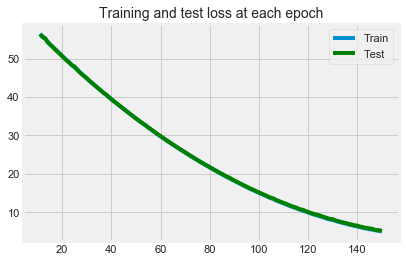

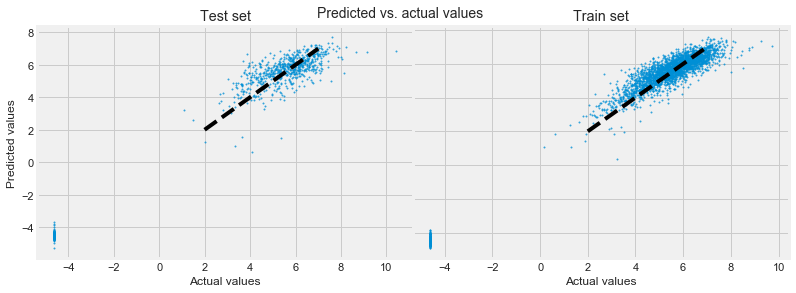

In [332]:
nn_model_evaluation(nn4, skip_epochs=10)

### Summary

In [334]:
# Calculat the prediction accuracy
acc_nn2 = nn2.evaluate(X_test, y_test, verbose= 0)[1]
acc_nn3 = nn3.evaluate(X_test, y_test, verbose= 0)[1]
acc_nn4 = nn4.evaluate(X_test, y_test, verbose= 0)[1]

print("Three Layer Neural Network:{:0.2f}%".format(acc_nn2))
print("Four Layer Neural Network with L1 Regularization and More Epochs:{:0.2f}%".format(acc_nn3))
print("Four Layer Neural Network with SGD Optimizern:{:0.2f}%".format(acc_nn4))

print('Improvement of {:0.2f}%.'.format( 100 * (acc_nn3 - acc_nn2) / acc_nn2))
print('Improvement of {:0.2f}%.'.format( 100 * (acc_nn4 - acc_nn2) / acc_nn2))

Three Layer Neural Network:0.95%
Four Layer Neural Network with L1 Regularization and More Epochs:0.68%
Four Layer Neural Network with SGD Optimizern:0.62%
Improvement of -27.84%.
Improvement of -34.49%.


Let's compare our neural network models above,


   Model                                                         |   Accuracy   |   Improvement(to base model)
---------------------------------------------------------------- | -------------| -----------------------------
Three Layer Neural Network                                       | 93.30%       |  - 
Four Layer Neural Network with L1 Regularization and More Epochs | 68.79%       |  -26.26%
Four Layer Neural Network with SGD Optimizern                    | 67.88%       |  -27.23%

It looks like the shallower three layer Neural Network gain the best performance.

## 5. Conclusion & Recommandation
<a id="cr"> </a>
Compared to the best random forest model with an accuracy of 90.06%, the Three Layer Neural Network	would be a better choice for predicting the yield.